In [2]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import cv2
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from IPython.display import Image, display

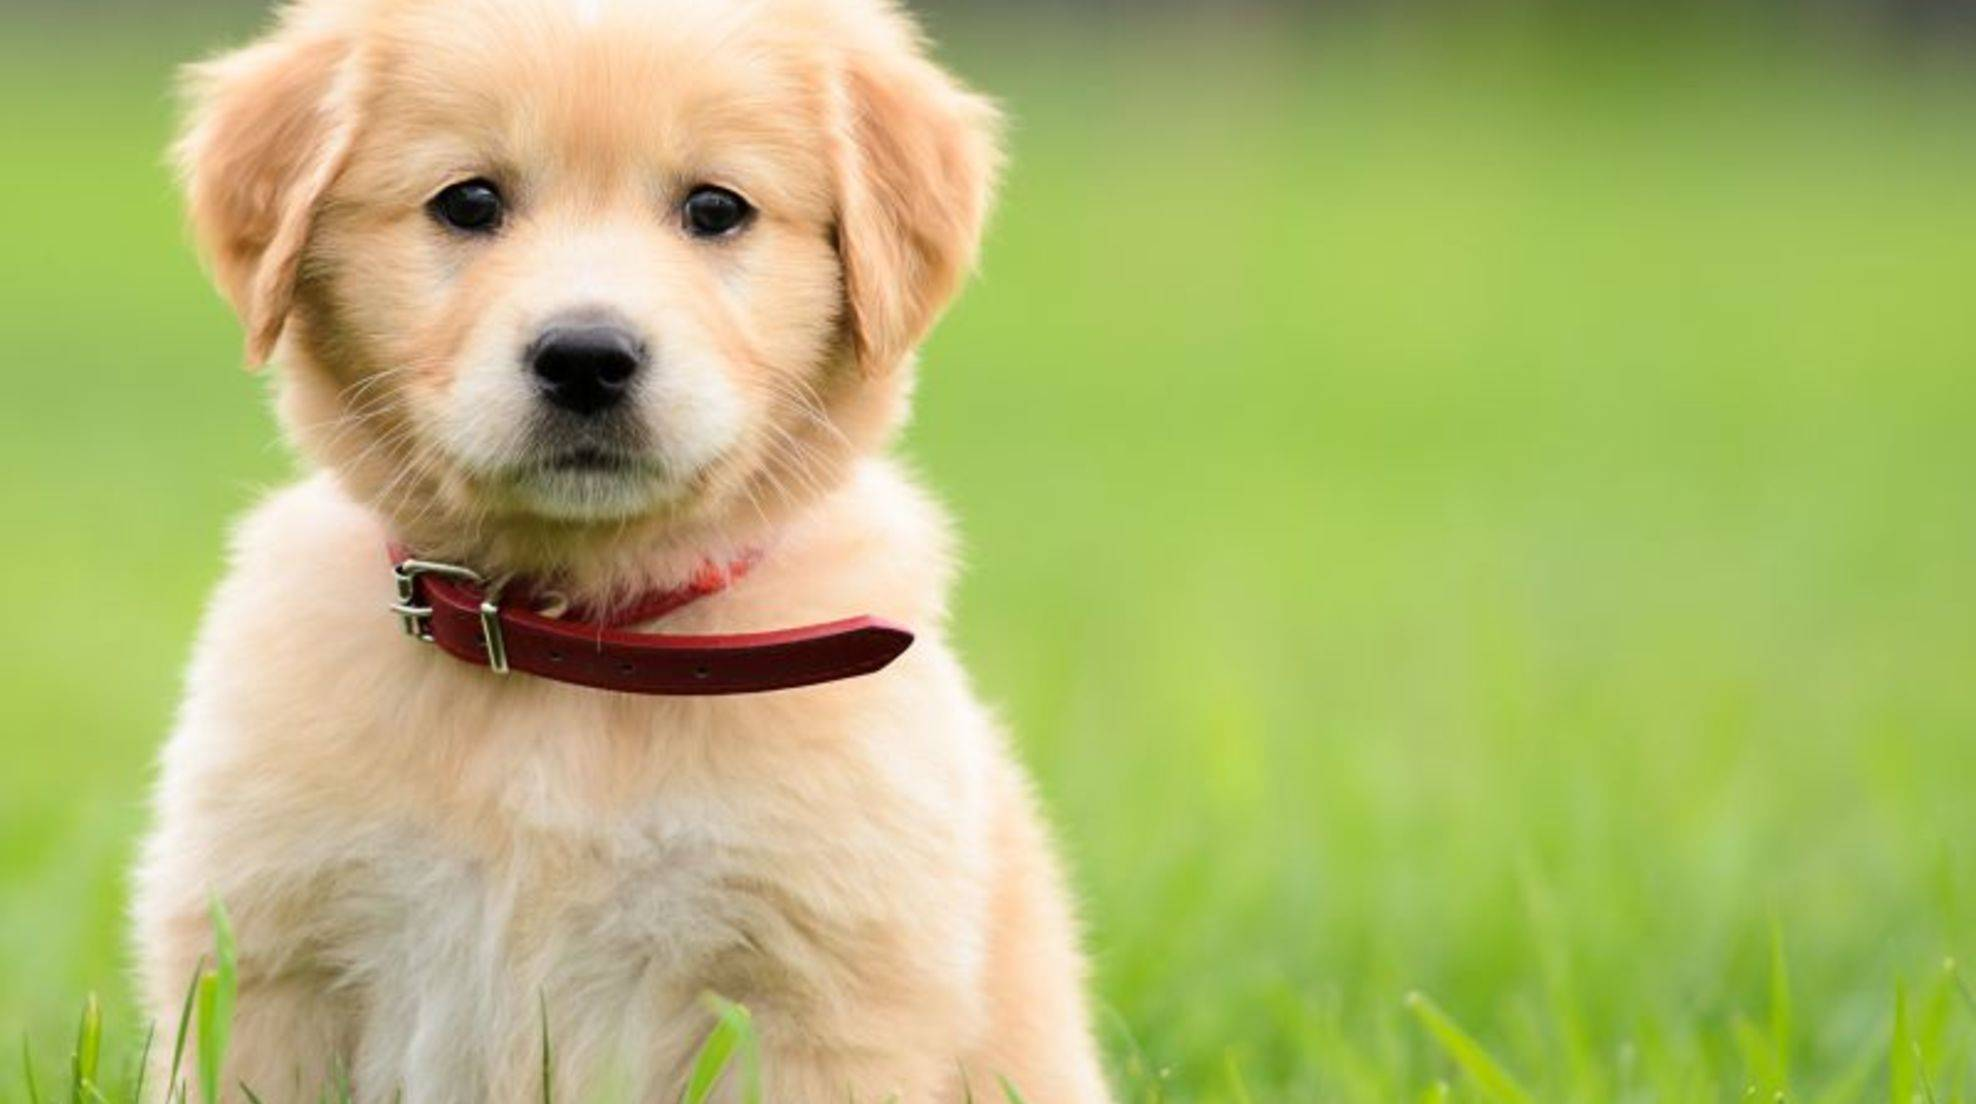

In [3]:
model_builder = tf.keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = tf.keras.applications.xception.preprocess_input
decode_predictions = tf.keras.applications.xception.decode_predictions

last_conv_layer_name = 'block14_sepconv2_act'

# The local path to our target image
img_path = tf.keras.utils.get_file(
    'african_elephant.jpg', 'https://i.imgur.com/Bvro0YD.png'
)

display(Image(img_path))

In [4]:
def load_img(img_path, size=None):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    return img


def get_img_array(img_path, size):
    img_array = load_img(img_path, size)
    # We add a dimension to transform our array into a 'batch'
    # of size (1, 299, 299, 3)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


def get_preprocessed_img(img_path, size):
    img_array = get_img_array(img_path, size)
    return preprocess_input(img_array)

In [5]:
def generate_cam(img_array, model, last_conv_layer_name, pred_index=None, respond=False):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(
            last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Grad-CAM would introduce here a vector where each entry would be the mean
    # intensity of the gradient over a specific feature map channel (equivalent
    # to global average pooling)
    # pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    # However, HiResCAM skips the gradient averaging step in order to retain
    # the relationship between the model explanation and the score calculation.

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class,
    # then sum all the channels to obtain the heatmap class activation.
    last_conv_layer_output = last_conv_layer_output[0]

    if respond:
        # Respond-CAM is fairly similar to HiResCAM but it uses weighted,
        # instead of raw, feature maps
        respond_weights = np.sum(last_conv_layer_output * grads, axis=(0, 1, 2)) / \
            (np.sum(last_conv_layer_output + 1e-10, axis=(0, 1, 2)))

        heatmap = last_conv_layer_output * respond_weights
    else:
        heatmap = last_conv_layer_output * grads
    heatmap = np.sum(heatmap, axis=-1)
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    # Notice that we clip the heatmap values, which is equivalent to applying ReLU
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 [==============================] - 2s 2s/step
Predicted: [('n02099601', 'golden_retriever', 10.416113)]


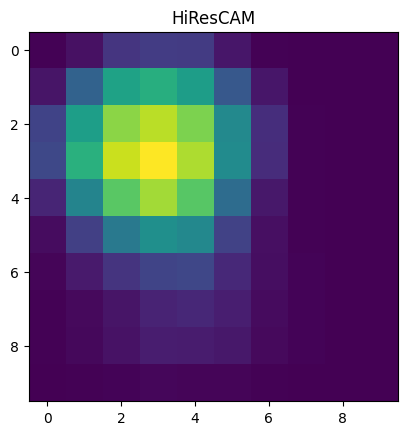

In [6]:
# Prepare image
img_array = get_preprocessed_img(img_path, size=img_size)

# Make model
model = model_builder(weights='imagenet')

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print('Predicted:', decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = generate_cam(img_array, model, last_conv_layer_name)
""" respond_heatmap = generate_cam(
    img_array, model, last_conv_layer_name, respond=True) """

# Display heatmap
plt.imshow(heatmap)
plt.title('HiResCAM')
#fig = plt.figure(constrained_layout=True, figsize=(10, 5))
#axes = fig.subplots(1, 1)

#axes[0].set_title('HiResCAM')
#axes[0].matshow(heatmap)
#axes[1].set_title('Respond-CAM')
#axes[1].matshow(respond_heatmap)
plt.show()

In [9]:
def resize_heatmap(img_path, heatmap):
    # Load the original image
    img = load_img(img_path)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap('jet')

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    return jet_heatmap


resized_heatmap = resize_heatmap(img_path, heatmap)
#resized_respond_heatmap = resize_heatmap(img_path, respond_heatmap)

C:\Users\hadie\AppData\Local\Temp\ipykernel_27968\3541843386.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap('jet')


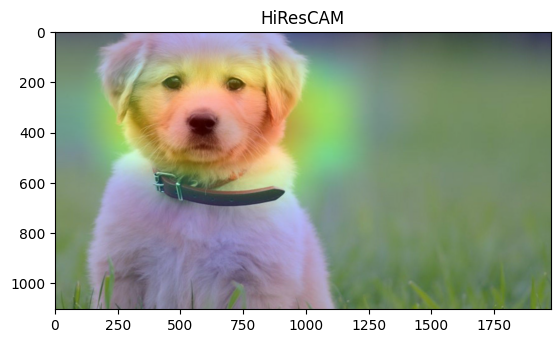

In [11]:
# respondcam_img wurde aus der Paramterliste entfernt 
def visualize_side_by_side(hirescam_img):
    plt.imshow(hirescam_img)
    plt.title('HiResCAM')
    #fig = plt.figure(constrained_layout=True, figsize=(20, 10))
    #axes = fig.subplots(1, 2)

    #axes[0].set_title('HiResCAM')
    #axes[0].imshow(hirescam_img)
    #axes[1].set_title('Respond-CAM')
    #axes[1].imshow(respondcam_img)
    plt.show()
def superimpose_heatmap(img, heatmap, alpha=0.4):
    superimposed_img = heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(
        superimposed_img)

    return superimposed_img


original_img = load_img(img_path)
superimposed_img = superimpose_heatmap(original_img, resized_heatmap)
""" superimposed_respond_img = superimpose_heatmap(
    original_img, resized_respond_heatmap) """

#visualize_side_by_side(superimposed_img, superimposed_respond_img)
visualize_side_by_side(superimposed_img)